In [16]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

!pip install spectral
import spectral

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
def loadDataSet(name):
    if name == 'IP':
        img = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
        gt = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']
        labels = ['unknown','Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                  ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                  'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                  'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                  'Stone-Steel-Towers']
        rgb_bands = (29, 19, 9)
        spatial_resolution = 20 

    elif name == 'SAL':
        img = sio.loadmat('Salinas_corrected')['Salinas_corrected']
        gt = sio.loadmat('Salinas_gt.mat')['salinas_gt']
        labels = ["unknown","Brocoli_green_weeds_1", "Brocoli_green_weeds_2",
			                      "Fallow", "Fallow_rough_plow", "Fallow_smooth", "Stubble",
			                      "Celery", "Grapes_untrained", "Soil_vinyard_develop", "Corn_senesced_green_weeds",
			                      "Lettuce_romaine_4wk", "Lettuce_romaine_5wk", "Lettuce_romaine_6wk", "Lettuce_romaine_7wk",
			                      "Vinyard_untrained", "Vinyard_vertical_trellis",]
        rgb_bands = (29, 19, 9)
        spatial_resolution = 3.7 

    elif name == 'PU':
        img = sio.loadmat('PaviaU.mat')['paviaU']
        gt = sio.loadmat('PaviaU_gt.mat')['paviaU_gt']
        labels = ["unknown","Asphalt", "Meadows", "Gravel", "Trees", "Painted metal sheets",
			            "Bare Soil", "Bitumen", "Self-Blocking Bricks", "Shadows",]
        rgb_bands = (53,31,8)
        spatial_resolution = 1.3

    elif name == 'KSC': 
        img = sio.loadmat("KSC.mat")["KSC"]
        gt = sio.loadmat("KSC_gt.mat")["KSC_gt"]
        labels = ["Undefined", "Scrub", "Willow swamp", "Cabbage palm/hammock", 
                  "Cabbage palm/oak hammock", "Slash pine", "Oak/broadleaf hammock", 
                  "Hardwood swamp", "Graminoid marsh", "Spartina marsh", "Cattail marsh", "Salt marsh",
                  "Mud flats", "Water",
                  ]
        rgb_bands = (29, 19, 9)
        spatial_resolution = 18
    else:
      print(name + " Dataset is not defined in the function. Please ensure the name is correct or if the loading is defined") 
      return None, None, None, None, None

    return img, gt, labels, rgb_bands, spatial_resolution

In [18]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [19]:
def applyScaling(X):
    newX = np.reshape(X, (-1, X.shape[2]))
    sc = MinMaxScaler()
    newX = sc.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], X.shape[2]))
    return newX, sc

In [20]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X    
    return newX

In [21]:
def createPatches(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)

    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1

    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
        
    return patchesData, patchesLabels

In [22]:
def splitTrainTestSet(X, y, trainRatio=0.70, randomState = 0):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=trainRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test

In [23]:
def plotExplainedVarienceRatio(X, numComponents=75):
    #Find best number of principal components to apply to the dataset
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    ev = pca.explained_variance_ratio_
    
    #plot a chart to see Cumulative varience ratio
    plt.figure(figsize=(12, 6))
    plt.plot(np.cumsum(ev))
    plt.xlabel('Number of components')
    plt.ylabel('Cumulative explained variance')
    
    plt.show()

In [24]:
def checkWindowSize(WS, height, width):
  if isinstance(WS, int):
      if WS < 5:
          print("Patch Size cannot be less than 5")
      if WS >= height or WS<=width:
          print("Patch Size cannot be bigger than Image")
  else:
    print("Please enter a valid Odd integer for Patch Size")

## Global Variables
In the below code cell, we define the variables which will be used through out our project.
* **name** : Name of the dataset.
* **windowSize** : This defines the patch size i.e the number of surrounding pixels the user wants the model to consider.
* **trainRatio** : The percentage of dataset the user wants to allocate for training.
* **EPOCH** : The total number of training cycles.
* **BATCH_SIZE** : A hyperparameter (Larger the batch size the faster the training per epoch).

In [25]:
#GLOBAL VARIABLES
# Datset Name values IP, SAL, PU, KSC
name = 'IP'

#Odd number
windowSize = 5

trainRatio = 0.90 

EPOCH = 5

BATCH_SIZE = 256

In [26]:
X, gt, labels, rgb_bands, spatial_resolution = loadDataSet(name)

In [27]:

numOfClasses = len(np.unique(gt))-1
numOfClasses

print(f"Image dimentions : {X.shape}\n\nTotal number of pixels = {X.shape[0] * X.shape[1]}\n\nNumber of classes = {numOfClasses}\n\nSpatial Resolution = {spatial_resolution} m\u00b2\n\nRGB bands = {rgb_bands}")

val, counts = np.unique(gt, return_counts=True)
print("\n\n------ Avaliable Samples ------")
for i in range(len(labels)):
  print("{0:30}  {1}".format(labels[i], counts[i]))

Image dimentions : (145, 145, 200)

Total number of pixels = 21025

Number of classes = 16

Spatial Resolution = 20 m²

RGB bands = (29, 19, 9)


------ Avaliable Samples ------
unknown                         10776
Alfalfa                         46
Corn-notill                     1428
Corn-mintill                    830
Corn                            237
Grass-pasture                   483
Grass-trees                     730
Grass-pasture-mowed             28
Hay-windrowed                   478
Oats                            20
Soybean-notill                  972
Soybean-mintill                 2455
Soybean-clean                   593
Wheat                           205
Woods                           1265
Buildings-Grass-Trees-Drives    386
Stone-Steel-Towers              93


## Show the color image
The color image is extracted from the dataset by selecting the corresponding RGB bands from the dataset.

/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


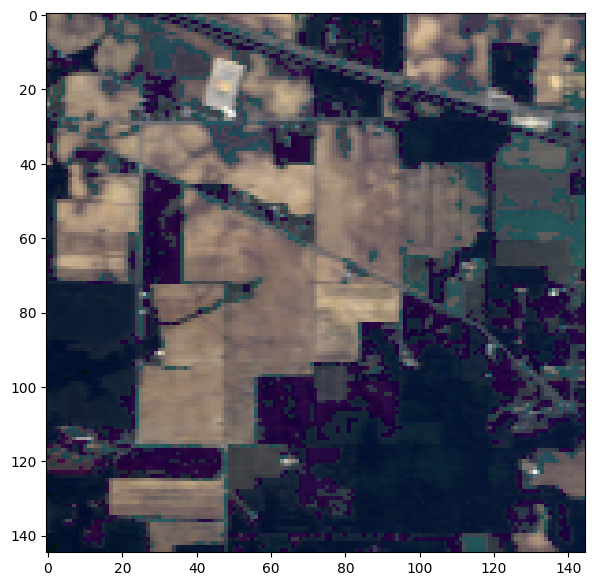

In [28]:
view = spectral.imshow(X, rgb_bands, figsize=(7,7))

##Plot the Ground Truth with legend
* Ground Truth represents facts about the image using numbers, where each number represnts a class to which a particular pixel belongs to.
* Legend maps a class in the ground truth to a color code.
* This is provides a visualization of the labeled pixels in the dataset,


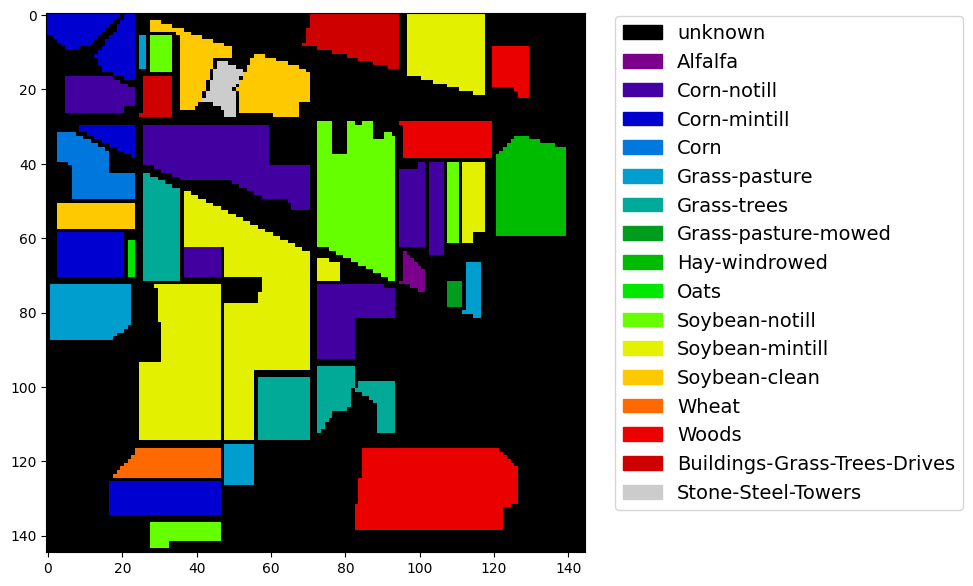

In [29]:
values = np.unique(gt.ravel())
plt.figure(figsize=(7,7))
im = plt.imshow(gt,cmap='nipy_spectral',interpolation='none')
colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0.15 , fontsize=14)
plt.show()

## See the pixel vector
With hyperspectral Image, each pixel has an array of values from band-1 to band- N. The below code cell plots the spectral range of a particular pixel.

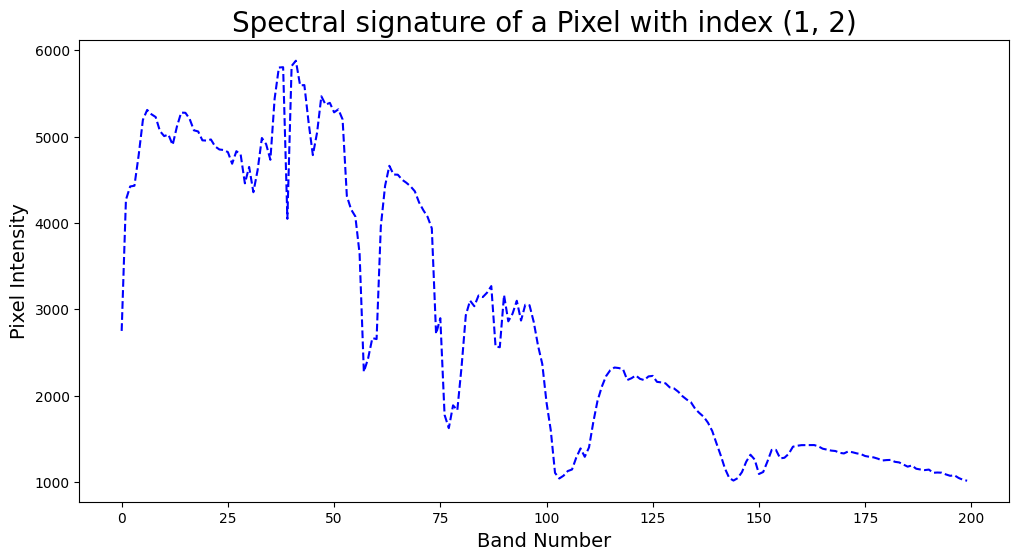

In [30]:
def plot_signature(X, i, j):
    plt.figure(figsize=(12, 6))
    plt.plot(X[i, j, :].tolist(), 'b--')
    plt.title(f'Spectral signature of a Pixel with index {i, j}', fontsize=20)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()

plot_signature(X, 1, 2)

In [31]:
X, sc = applyScaling(X)

## Graph to analyse the Variance ratio
* The variance ratio tells us how many number of components are needed from a PCA applied image to express the corresponding percentage of information.(More components represents more information)
* The below code cell provides a graphical representation of number of components to variance.
* We try to select the optimum number of components that can best express the information from the original image.

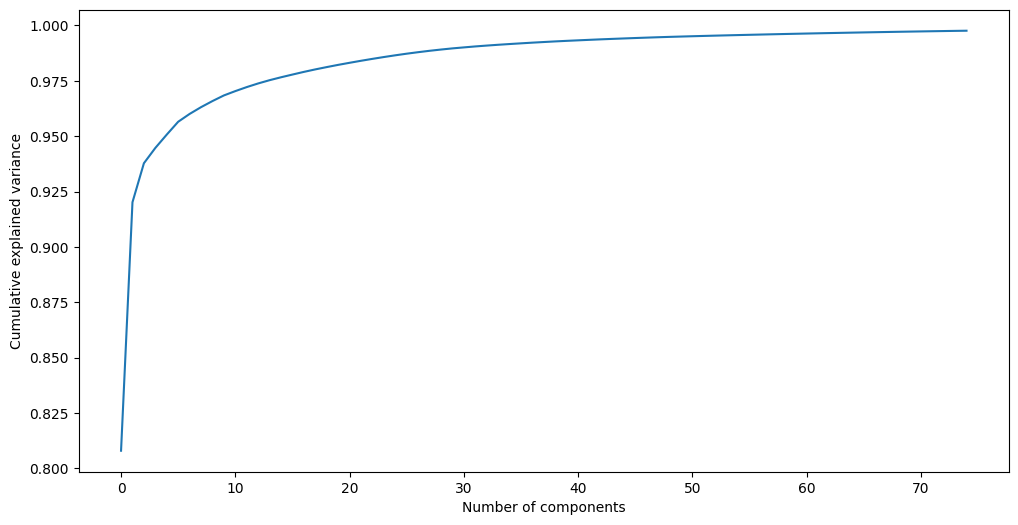

In [32]:
plotExplainedVarienceRatio(X)

## Principal components 
Select the number of principal components based on the output of previous code cell
1. Indian Pines (IP) = 60 
1. University of Pavia (UP) = 15 
1. Salinas (SAL) = 15 
1. Kennedy Space Center (KSC) = 75

In [33]:
numPCA = 15

In [34]:
X, pca = applyPCA(X, numPCA)
print(f"Dimension of image after PCA = {X.shape}")

Dimension of image after PCA = (145, 145, 15)


## Convert to Patches
In this code cell, we take into account the spectral and spatial characteristics. For each pixel, we take its neighbourhood pixel whose value is the previosuly defined global variable **windowSize**.

In [35]:
X_Patches, y_Patches = createPatches(X, gt, windowSize=windowSize)
X_Patches.shape, y_Patches.shape

((10249, 5, 5, 15), (10249,))

## Split the dataset into Training set and Testing set
In this code cell, we take the previously obtained patches, split them into training set and testing set as per the global variable **trainRatio**

In [36]:
X_train, X_test, y_train, y_test = splitTrainTestSet(X_Patches, y_Patches, trainRatio)

In [37]:
#Clear from memory done so that there is no memory overflow
del X_Patches
del y_Patches

In [38]:
print(f"Training Sample Size : {y_train.shape}\n\nTest Sample Size = {y_test.shape}")

val1, counts1 = np.unique(y_train, return_counts=True)
val2, counts2 = np.unique(y_test, return_counts=True)

print("\n\n----------  Training Samples  ---------\t\t----------  Testing Samples  ----------")
for i in range(len(val1)):
  print("{0:30}  {1}".format(labels[i+1], counts1[i]) + "\t\t" + "{0:30}  {1}".format(labels[i+1], counts2[i]) )

Training Sample Size : (9224,)

Test Sample Size = (1025,)


----------  Training Samples  ---------		----------  Testing Samples  ----------
Alfalfa                         41		Alfalfa                         5
Corn-notill                     1285		Corn-notill                     143
Corn-mintill                    747		Corn-mintill                    83
Corn                            213		Corn                            24
Grass-pasture                   435		Grass-pasture                   48
Grass-trees                     657		Grass-trees                     73
Grass-pasture-mowed             25		Grass-pasture-mowed             3
Hay-windrowed                   430		Hay-windrowed                   48
Oats                            18		Oats                            2
Soybean-notill                  875		Soybean-notill                  97
Soybean-mintill                 2209		Soybean-mintill                 246
Soybean-clean                   534		Soybean-clean                  

## Convert the catagorical variable into one-hot encoded array
* In this code cell, the catagorical classes like 1, 2, 3 .. N are converted to one-hot encoded array represented by [0, 0 ,0 ...... 1.0].
* Here, the index of 1.0 represents the class N

In [39]:
from keras.utils import np_utils

X_train = X_train.reshape(-1, windowSize, windowSize, numPCA)
X_test = X_test.reshape(-1, windowSize, windowSize, numPCA )

# convert class labels to one-hot encoded variables
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

## Import relavent modules for Convolutional Neural Network

In [40]:
import keras
import keras.layers as layers

from keras.models import Sequential
from keras.layers import Conv3D, Flatten, Dense, add
from keras.layers import concatenate
from keras.layers import Dropout, Input

from keras.models import Model
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

from keras.callbacks import ModelCheckpoint

## Define Mish activation function
Keras does not have an implementation for Mish activation, and hence we are defining it in the below code cell.
<br><br>
The Mish Activation is given by the expression below:
<br>
Mish(x) = x * tanh(log(1 + $e^{x}$)

In [41]:
import tensorflow as tf
def mish(x):
	return tf.keras.layers.Lambda(lambda x: x*tf.tanh(tf.math.log(1+tf.exp(x))))(x)

In [42]:
pad = 'same' if windowSize < 11 else 'valid'

## Define the Convolutional Neural Network
In the below code cell, we are defining all the layers of the proposed Convolutional Neural Network 

In [43]:
# input layer
input = Input((windowSize, windowSize, numPCA, 1))

x = Conv3D(filters=64, kernel_size=(3, 3, 3), padding=pad, activation=mish)(input)
print(f"spectral-spatial : {x.shape}")

x = Conv3D(filters=64, kernel_size=(3, 3, 3), padding=pad, activation=mish)(x)
print(f"spectral-spatial : {x.shape}")

x = Conv3D(filters=64, kernel_size=(3, 3, 3), padding=pad, activation=mish)(x)
print(f"spectral-spatial : {x.shape}")

# Spatial feature extraction sub network
x2 = Conv3D(filters=128, kernel_size=(3, 3, 1), padding='same',activation=mish)(x)
print(f"spatial : {x2.shape}")

x2 = Conv3D(filters=128, kernel_size=(3, 3, 1), padding='valid',activation=mish)(x2)
print(f"spatial : {x2.shape}")

x2 = Conv3D(filters=128, kernel_size=(3, 3, 1), padding='valid',  activation=mish)(x2)
print(f"spatial : {x2.shape}")

# Spectral feature extraction sub network
xs = x.shape
x3 = Conv3D(filters=128, kernel_size=(xs[1], xs[2], 3), padding='valid', activation=mish)(x)
print(f"spectral : {x3.shape}")

x3 = Conv3D(filters=128, kernel_size=(1, 1, 3), padding='valid', activation=mish)(x3)
print(f"spectral : {x3.shape}")

x3 = Conv3D(filters=128, kernel_size=(1, 1, 3), padding='valid', activation=mish)(x3)
print(f"spectral : {x3.shape}")

x2 = Flatten()(x2)
x3 = Flatten()(x3)

x = concatenate([ x2, x3], axis=-1)
print(x.shape[1])

x = Dense(units=1024,  activation=mish)(x)
x = Dropout(0.4)(x)

x = Dense(units=1024, activation=mish)(x)
x = Dropout(0.4)(x)

x = Dense(units=512, activation=mish)(x)
x = Dropout(0.4)(x)

x = Dense(units=512, activation=mish)(x)
x = Dropout(0.4)(x)

output = Dense(units=numOfClasses, activation='softmax')(x)

spectral-spatial : (None, 5, 5, 15, 64)
spectral-spatial : (None, 5, 5, 15, 64)
spectral-spatial : (None, 5, 5, 15, 64)
spatial : (None, 5, 5, 15, 128)
spatial : (None, 3, 3, 15, 128)
spatial : (None, 1, 1, 15, 128)
spectral : (None, 1, 1, 13, 128)
spectral : (None, 1, 1, 11, 128)
spectral : (None, 1, 1, 9, 128)
3072


In [44]:
# define the model with input layer and output layer
model = Model(inputs = input, outputs = output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 5, 15, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv3d (Conv3D)                (None, 5, 5, 15, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv3d_1 (Conv3D)              (None, 5, 5, 15, 64  110656      ['conv3d[0][0]']                 
                                )                                                             

## Instantiating the optimizer and loss function
* The loss function calculates the loss occured in each training cycle.
* The optimizer takes the output of the loss function and optimizes the weights in the network
* This is repeated at the end of each training cycle

In [45]:
#hyperparameters
adam = Adam(learning_rate=0.0001, decay=1e-05)
loss = CategoricalCrossentropy()
model.compile(loss=loss, optimizer=adam, metrics=['accuracy'])

In [46]:
filepath = name + "-best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

## Start the training

In [47]:
import time

start = time.time()
#Fit the training set into the model
history = model.fit(x = X_train, y = y_train, batch_size = BATCH_SIZE, epochs = EPOCH, callbacks=callbacks_list)

print("--- %s seconds ---" % (time.time() - start))

Epoch 1/5
37/37 [==============================] - ETA: 0s - loss: 2.1804 - accuracy: 0.4934
Epoch 1: accuracy improved from -inf to 0.49339, saving model to IP-best-model.hdf5
37/37 [==============================] - 20s 125ms/step - loss: 2.1804 - accuracy: 0.4934
Epoch 2/5
36/37 [============================>.] - ETA: 0s - loss: 0.9548 - accuracy: 0.6793
Epoch 2: accuracy improved from 0.49339 to 0.67942, saving model to IP-best-model.hdf5
37/37 [==============================] - 4s 107ms/step - loss: 0.9545 - accuracy: 0.6794
Epoch 3/5
36/37 [============================>.] - ETA: 0s - loss: 0.6303 - accuracy: 0.7783
Epoch 3: accuracy improved from 0.67942 to 0.77851, saving model to IP-best-model.hdf5
37/37 [==============================] - 4s 109ms/step - loss: 0.6298 - accuracy: 0.7785
Epoch 4/5
36/37 [============================>.] - ETA: 0s - loss: 0.4769 - accuracy: 0.8339
Epoch 4: accuracy improved from 0.77851 to 0.83391, saving model to IP-best-model.hdf5
37/37 [========

## Plot accuracy
With each training cycle, the training accuracy and the testing accuracy is plotted.

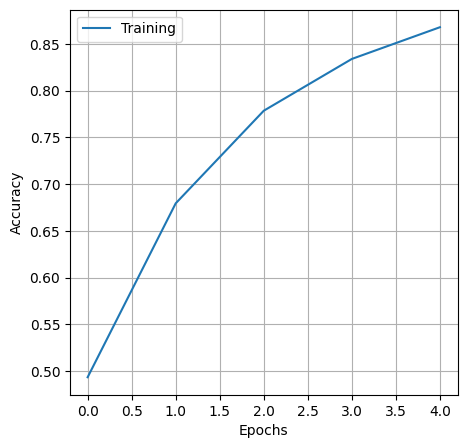

In [48]:
plt.figure(figsize=(5,5)) 
plt.grid() 
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy') 
plt.xlabel('Epochs') 
plt.legend(['Training','Test']) 
plt.show()

In [49]:
# load best weights for the model
filepath = name + "-best-model.hdf5"

model.load_weights(filepath)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [50]:
# # Download the weights for later use
# from google.colab import files
# files.download(filepath)

In [51]:
def reports (X_test,y_test, labels):
    Y_pred = model.predict(X_test)
    
    y_pred = np.argmax(Y_pred, axis=1)

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=labels)

    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)

    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

    each_acc, aa = AA_andEachClassAccuracy(confusion)

    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

    score = model.evaluate(X_test, y_test, batch_size=64)

    Test_Loss =  score[0]*100

    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [52]:
from operator import truediv
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]

    list_diag = np.diag(confusion_matrix)

    list_raw_sum = np.sum(confusion_matrix, axis=1)

    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))

    average_acc = np.mean(each_acc)

    return each_acc, average_acc

In [53]:
def plotConfusion(confusion, labels):
    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(confusion)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(labels)-1))
    ax.set_yticks(np.arange(len(labels)-1))

    # ... and label them with the respective list entries
    ax.set_xticklabels(labels[1:])
    ax.set_yticklabels(labels[1:])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)-1):
        for j in range(len(labels)-1):
            text = ax.text(j, i, confusion[i, j], ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    # fig.tight_layout()
    plt.show()

## Metrices used for the evaluation of model performance
**Overall Accuracy** : This is given by the number of correct predictions/ Total number of predictions. This is a general look at model performance
<br> 
OA = ${Correct Predictions}/{Total Number of Predictions}$
<br>
<br>
**Each Class Accuracy** : This gives the accuracy attained for each class in the dataset. This value is an indicator of the performance of each class.
<br>
AA = ${Correct Predictions per class}/{Total Number of Predictions per class}$
<br>
<br>
**Average Accuracy** : It is the average of *Each Class Accuracy*, this gives us a more robust form of accuracy as it takes into account the weightage of all the classes in the dataset.
<br>
AA = $Avg(Each Class Accuracy)$
<br>
<br>
**Kappa co-efficent** : It represents the agreement between the ground truth and the model. It is given by the expression
<br>
$KA = {(total accuracy – random accuracy) / (1- random accuracy)}$
<br>
<br>

In [54]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(X_test,y_test, labels[1:])
print()
print("Overall Accuracy = " + str(oa) + "\nAverage Accuracy = " + str(aa) + "\nKappa coefficient = " + str(kappa))

class_name = labels[1:]


print("\n\n------ Each Class Accuracy ------")
for i in range(len(each_acc)):
  print("{0:30}  {1}".format(labels[i+1], each_acc[i]))

17/17 [==============================] - 1s 10ms/step - loss: 0.2462 - accuracy: 0.9171

Overall Accuracy = 91.70731707317074
Average Accuracy = 86.86865775782643
Kappa coefficient = 90.54030724864904


------ Each Class Accuracy ------
Alfalfa                         40.0
Corn-notill                     83.91608391608392
Corn-mintill                    87.95180722891565
Corn                            79.16666666666666
Grass-pasture                   93.75
Grass-trees                     98.63013698630137
Grass-pasture-mowed             100.0
Hay-windrowed                   100.0
Oats                            50.0
Soybean-notill                  89.69072164948454
Soybean-mintill                 93.90243902439023
Soybean-clean                   93.22033898305084
Wheat                           100.0
Woods                           97.61904761904762
Buildings-Grass-Trees-Drives    82.05128205128204
Stone-Steel-Towers              100.0


In [55]:
print(classification)

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.40      0.57         5
                 Corn-notill       0.92      0.84      0.88       143
                Corn-mintill       0.97      0.88      0.92        83
                        Corn       0.73      0.79      0.76        24
               Grass-pasture       1.00      0.94      0.97        48
                 Grass-trees       0.96      0.99      0.97        73
         Grass-pasture-mowed       1.00      1.00      1.00         3
               Hay-windrowed       0.94      1.00      0.97        48
                        Oats       1.00      0.50      0.67         2
              Soybean-notill       0.88      0.90      0.89        97
             Soybean-mintill       0.91      0.94      0.93       246
               Soybean-clean       0.77      0.93      0.85        59
                       Wheat       1.00      1.00      1.00        20
                   

## Plot the Confusion Matrix
A confusion matrix provides a summary of the predictive results. Correct and incorrect predictions are summarized in a matrix with their values and broken down by each class.

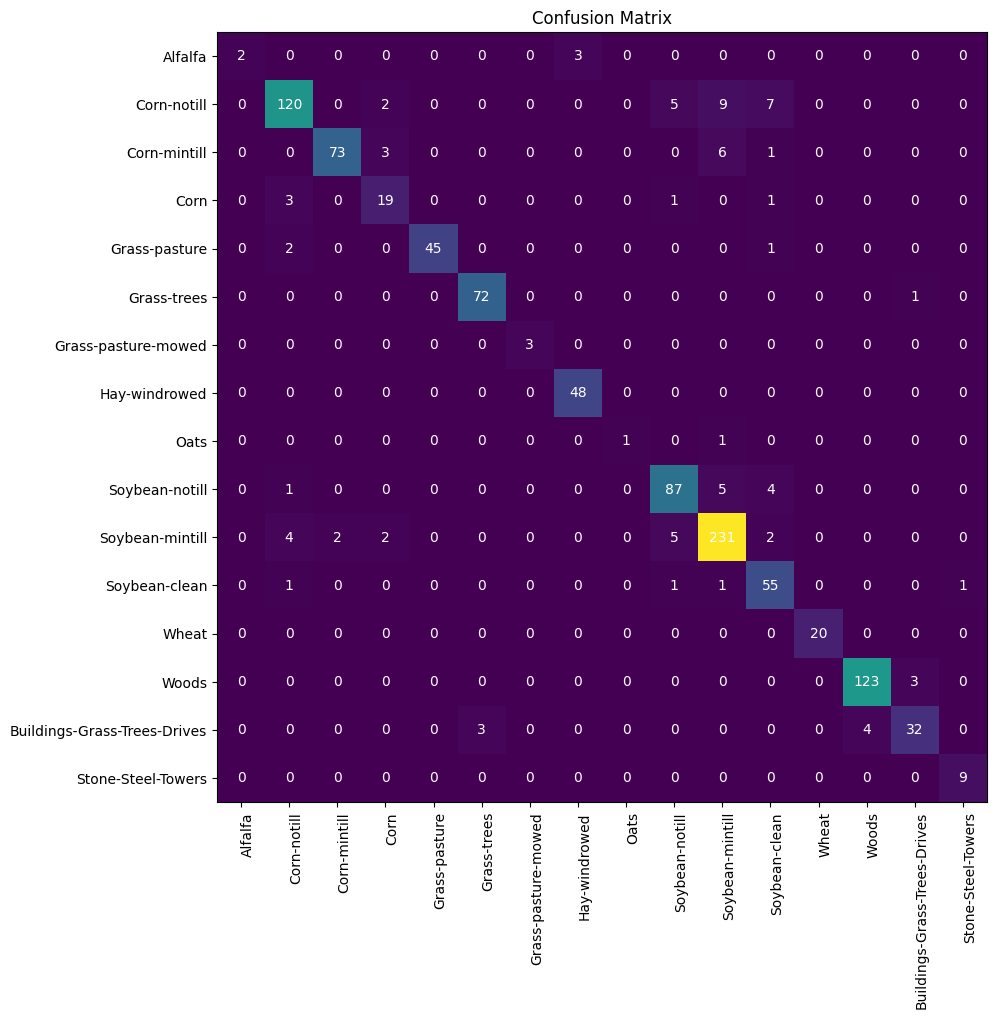

In [56]:
plotConfusion(confusion, labels)

## Plot the Predicted Ground Truth
Using our learned model, we predict the labelled samples of the dataset. This gives a estimate of which regions our model failed to classify.

In [57]:
X_Patches, y_Patches = createPatches(X, gt, windowSize=windowSize,removeZeroLabels=False)

In [58]:
y_pred = model.predict(X_Patches, batch_size=256)

83/83 [==============================] - 2s 29ms/step


In [59]:
print(f"Total number of predictions = {y_pred.shape}")

Total number of predictions = (21025, 16)


In [60]:
#Clear from memory
del X_Patches
del y_Patches

In [61]:
height = gt.shape[0]
width = gt.shape[1]

In [62]:
full_map = np.argmax(y_pred, axis=1)
full_map = full_map.reshape(height, width)

In [63]:
val3, counts3 = np.unique(full_map, return_counts=True)

In [64]:
for i in range(height):
  for j in range(width):
    full_map[i][j] = full_map[i][j] + 1

In [65]:
pred_gt = np.copy(full_map)
for i in range(height):
  for j in range(width):
    if gt[i][j] == 0:
      pred_gt[i][j] = 0

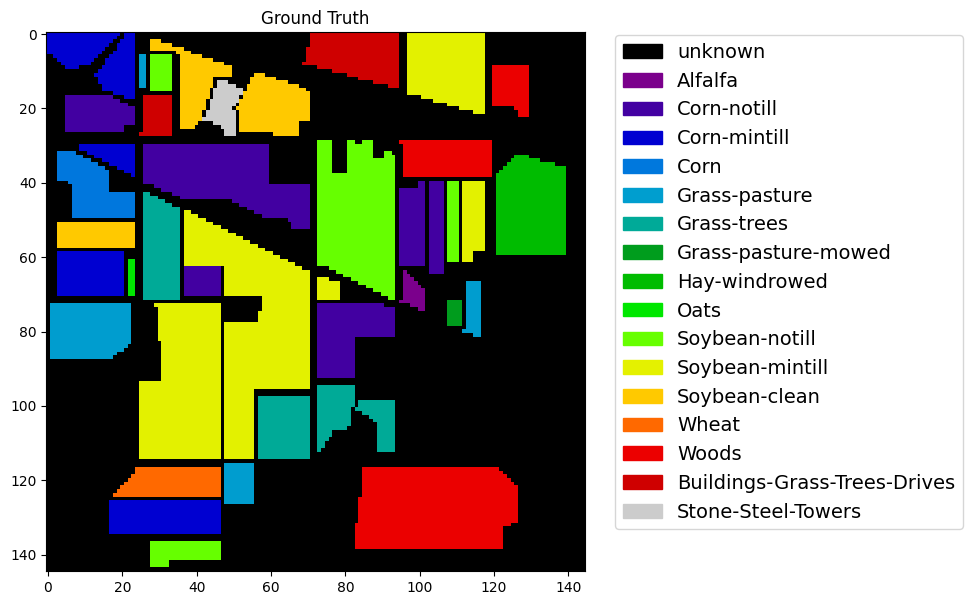

In [66]:
import matplotlib.patches as mpatches
values = np.unique(gt.ravel())

plt.figure(figsize=(7,7))
im = plt.imshow(gt, cmap='nipy_spectral',interpolation='none')

colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0.15 , fontsize=14)
plt.title("Ground Truth")
plt.show()

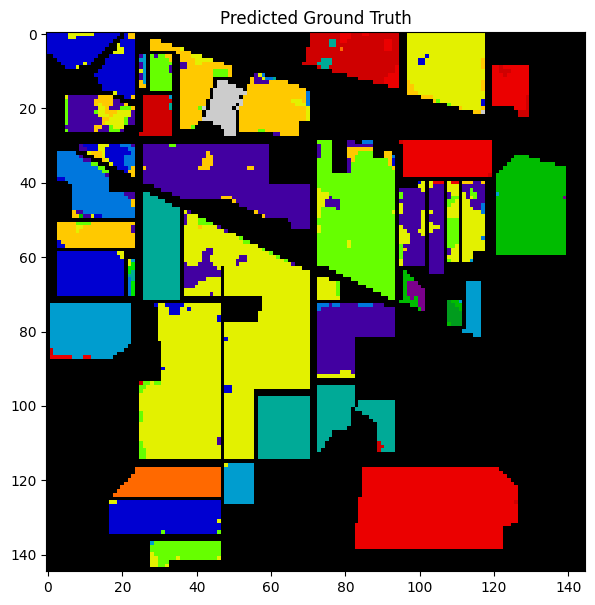

In [67]:
plt.figure(figsize=(7,7))
plt.imshow(pred_gt, cmap='nipy_spectral',interpolation='none')
plt.title("Predicted Ground Truth")
plt.show()

## Plot the classification Map
With the learned model, we predict for the unlabelled sample of the image.

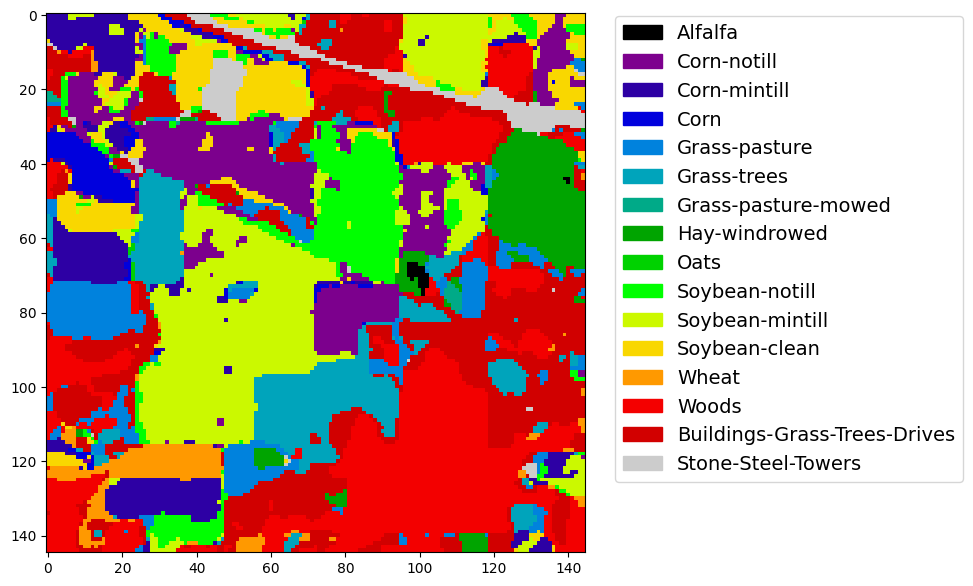

In [68]:
values = np.unique(full_map.ravel())

plt.figure(figsize=(7,7))
im = plt.imshow(full_map, cmap='nipy_spectral',interpolation='none')

colors = [ im.cmap(im.norm(value)) for value in values]
patches = [ mpatches.Patch(color=colors[i], label=labels[i+1]) for i in range(len(values)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1.0), loc=2, borderaxespad=0.15 , fontsize=14)
plt.show()

/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


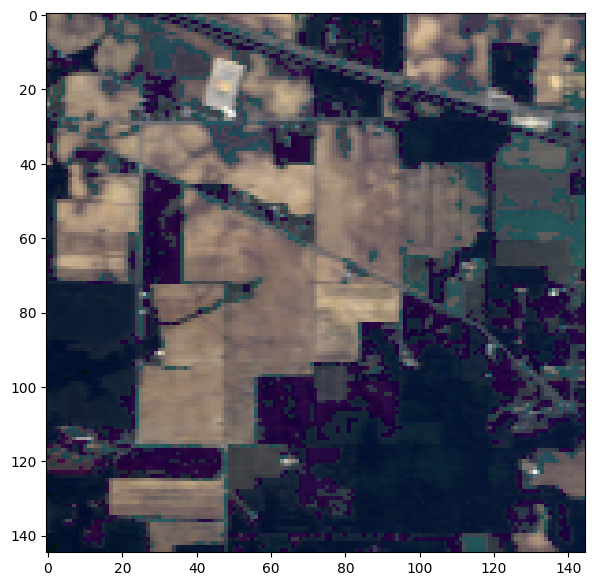

In [69]:
X, gt, labels, rgb_bands, spatial_resolution = loadDataSet(name)
view = spectral.imshow(X, rgb_bands, figsize=(7,7))

## Use case of Classification Map 
* From the above classification map, the physical distribution of each class in the image is obtained with a minimal patch unlike the existing models which require a large patch size.
* The proposed model has a high accuracy and hence the calculation of surface area predictions can be regarded with high confidence, which in turn reduces the manual efforts involved in calculating the same.  

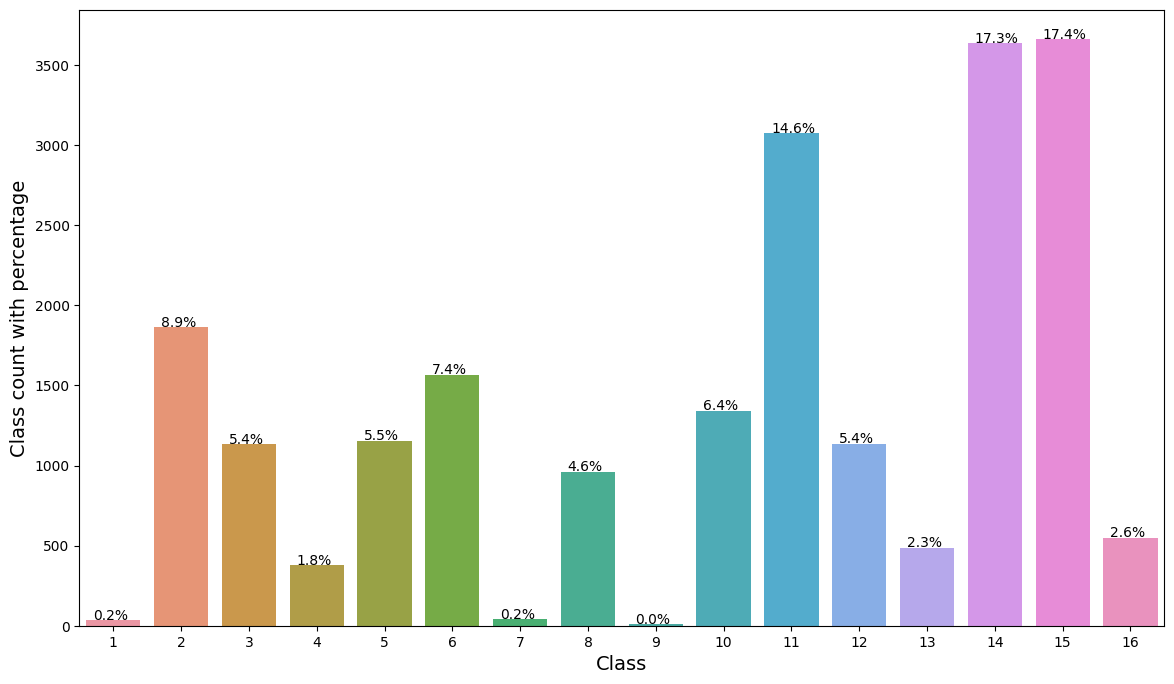

In [70]:
import seaborn as sns
plt.figure(figsize=(14, 8))
ax = sns.countplot(x=(np.argmax(y_pred, axis=1)+1))

for p in ax.patches:
  ax.annotate('{:.1f}%'.format(100*p.get_height()/y_pred.shape[0]), (p.get_x()+0.1, p.get_height()+5))

plt.ylabel('Class count with percentage', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.xlabel
patches = [ mpatches.Patch(color=colors[i], label=labels[i+1]) for i in range(len(values)) ]

plt.show()

In [71]:
pixels_count = height * width
print("------ Percentage Distribution ------\n")
for i in range(len(each_acc)):
  print("{0} \t {1:30}  {2} %".format(i+1, labels[i+1], (counts3[i]/pixels_count)*100))

------ Percentage Distribution ------

1 	 Alfalfa                         0.16171224732461356 %
2 	 Corn-notill                     8.86563614744352 %
3 	 Corn-mintill                    5.3840665873959574 %
4 	 Corn                            1.7931034482758619 %
5 	 Grass-pasture                   5.483947681331748 %
6 	 Grass-trees                     7.448275862068964 %
7 	 Grass-pasture-mowed             0.19500594530321044 %
8 	 Hay-windrowed                   4.565992865636147 %
9 	 Oats                            0.04756242568370987 %
10 	 Soybean-notill                  6.382877526753865 %
11 	 Soybean-mintill                 14.620689655172415 %
12 	 Soybean-clean                   5.403091557669441 %
13 	 Wheat                           2.316290130796671 %
14 	 Woods                           17.29845422116528 %
15 	 Buildings-Grass-Trees-Drives    17.417360285374553 %
16 	 Stone-Steel-Towers              2.6159334126040426 %
